총 단어 수: 17786개
가장 왼쪽(비둘기) 점수: -2.39
가장 오른쪽(매파) 점수: 2.28


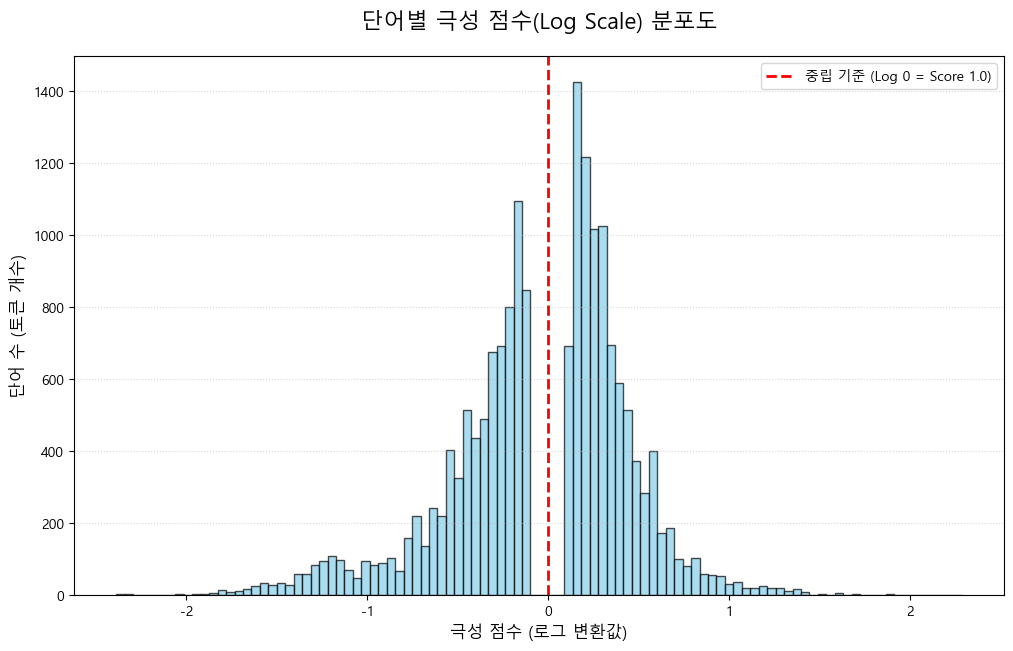

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. 한글 설정 (윈도우 맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 2. 파일 불러오기
file_path = r'C:\KDT\bok_pjt\team2_forecast_pjt\db\lexicon\total_lexicon.csv'
df = pd.read_csv(file_path)

# 3. 데이터 준비 (점수에 로그를 취해서 균형을 맞춥니다)
# 논문의 식(1)에 따른 비율 점수이므로 로그를 취해야 대칭이 보입니다.
df['log_score'] = np.log10(df['polarity_score'])

# 4. 그래프 그리기
plt.figure(figsize=(12, 7))

# 히스토그램 그리기
# bins=100은 '바구니 100개에 나눠 담기'라는 뜻이에요.
plt.hist(df['log_score'], bins=100, color='skyblue', edgecolor='black', alpha=0.7)

# 중립 기준선(log10(1.0) = 0) 그리기
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='중립 기준 (Log 0 = Score 1.0)')

# 그래프 꾸미기
plt.title('단어별 극성 점수(Log Scale) 분포도', fontsize=16, pad=20)
plt.xlabel('극성 점수 (로그 변환값)', fontsize=12)
plt.ylabel('단어 수 (토큰 개수)', fontsize=12)
plt.grid(True, axis='y', ls=':', alpha=0.5)
plt.legend()

# 5. 간단한 통계 수치 보여주기
print(f"총 단어 수: {len(df)}개")
print(f"가장 왼쪽(비둘기) 점수: {df['log_score'].min():.2f}")
print(f"가장 오른쪽(매파) 점수: {df['log_score'].max():.2f}")

plt.show()

In [5]:
import pandas as pd
import numpy as np

# 1. 파일 불러오기
file_path = r'C:\KDT\bok_pjt\team2_forecast_pjt\db\lexicon\total_lexicon.csv'
df = pd.read_csv(file_path)

# ---------------------------------------------------------
# [1단계] 로그 변환 (공평한 운동장 만들기)
# ---------------------------------------------------------
# 비율(Ratio) 점수를 로그로 바꿔야 비둘기(-값)와 매파(+값)가 대칭이 됩니다.
df['log_score'] = np.log10(df['polarity_score'])

# ---------------------------------------------------------
# [2단계] 블랙리스트 제거 (신문사 템플릿 노이즈)
# ---------------------------------------------------------
# 정답지가 아니라, 딱 봐도 '신문사 시스템 용어'인 것들만 수동으로 살짝 빼줄게요.
bad_words = ['기자', '포토', '뉴스', '무단', '전재', '배포', '금지', '구독', '신청', '갤러리', '화보', '티타임']
df_no_news = df[~df['word'].str.contains('|'.join(bad_words))]

# ---------------------------------------------------------
# [3단계] 로그 점수 기준 IQR 울타리 치기 (학생분의 아이디어!)
# ---------------------------------------------------------
# 그냥 점수가 아니라 '로그 점수'로 울타리를 쳐야 양쪽 꼬리가 공평하게 잘립니다.
Q1 = df_no_news['log_score'].quantile(0.25)
Q3 = df_no_news['log_score'].quantile(0.75)
IQR = Q3 - Q1

# 울타리 범위를 조금 더 좁게(1.5 -> 1.2) 잡으면 노이즈가 더 잘 빠져요.
lower_bound = Q1 - 1.2 * IQR
upper_bound = Q3 + 1.2 * IQR

df_clean = df_no_news[(df_no_news['log_score'] >= lower_bound) & (df_no_news['log_score'] <= upper_bound)]

# ---------------------------------------------------------
# 최종 결과 뽑기
# ---------------------------------------------------------
top_dovish = df_clean[df_clean['label'] == 'dovish'].nsmallest(10, 'log_score')
top_hawkish = df_clean[df_clean['label'] == 'hawkish'].nlargest(10, 'log_score')

print(f"--- 정제 완료 (울타리: {lower_bound:.2f} ~ {upper_bound:.2f}) ---")
print("\n[비둘기파 Top 10]\n", top_dovish[['word', 'polarity_score']].reset_index(drop=True))
print("\n" + "="*50)
print("\n[매파 Top 10]\n", top_hawkish[['word', 'polarity_score']].reset_index(drop=True))

--- 정제 완료 (울타리: -1.02 ~ 1.02) ---

[비둘기파 Top 10]
                                        word  polarity_score
0        노사/NNG;문화/NNG;우수기업/NNG;선정/NNG;되/VV        0.094965
1          되/VV;문의/NNG;상담/NNG;가능/NNG;문의/NNG        0.094976
2     금리/NNG;변화/NNG;은행채/NNG;등급별/NNG;금융채/NNG        0.095178
3        변화/NNG;금융/NNG;금융/NNG;금융/NNG;금융/NNG        0.095178
4  스프레드/NNG;변화/NNG;금융채/NNG;등급별/NNG;스프레드/NNG        0.095178
5      스프레드/NNG;변화/NNG;특수/NNG;은행/NNG;특수/NNG        0.095178
6          금리/NNG;인하/NNG;단행/NNG;하/VV;전망/NNG        0.095380
7       은행/NNG;담보대출/NNG;금리/NNG;비교/NNG;통하/VV        0.095682
8                      현물환/NNG;종가/NNG;내리/VV        0.095915
9          야릇/NNG;자세/NNG;유혹/NNG;하/VV;될까요/VV        0.096065


[매파 Top 10]
                                     word  polarity_score
0   fed/NNG;연속/NNG;스텝/NNG;금리/NNG;포인트/NNG       10.565226
1          플/NNG;플/NNG;플/NNG;레/NNG;션/NNG       10.536655
2      그룹/NNG;따르/VV;시장/NNG;금리/NNG;인상/NNG       10.487009
3                            경계/NNG;크/VA       